# Experiment 9: Implementing a Neural Network and Backpropagation from Scratch

---

## 1. Learning Objectives
- Understand mathematical foundations of a feedforward ANN
- Implement NumPy-based activations and derivatives (ReLU, Sigmoid)
- Implement forward and backpropagation
- Implement BCE and MSE losses and gradient descent updates
- Build a modular `MyANNClassifier` using only NumPy
- Train on Breast Cancer dataset and evaluate
- Compare against `sklearn.neural_network.MLPClassifier`
- Analyze impact of loss functions and architectures


## 2. Prerequisites
```bash
pip install numpy pandas scikit-learn matplotlib
```


## 3. Task 1 — Data Loading & Preprocessing

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

X.shape, X_train.shape, X_val.shape

((569, 30), (398, 30), (171, 30))

## 4. Task 2 — Utilities (NumPy)

In [2]:
import numpy as np

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def sigmoid_derivative(A):
    return A * (1 - A)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def compute_bce_loss(Y, Y_hat, eps=1e-15):
    Y_hat = np.clip(Y_hat, eps, 1 - eps)
    m = Y.shape[1]
    return -np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)) / m

def compute_mse_loss(Y, Y_hat):
    m = Y.shape[1]
    return np.sum((Y_hat - Y) ** 2) / m


## 5. Task 3 — MyANNClassifier

In [3]:
class MyANNClassifier:
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce', seed=42):
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss = loss
        self.parameters_ = {}
        self.costs_ = []
        self.rng_ = np.random.default_rng(seed)

    def _initialize_parameters(self):
        self.parameters_ = {}
        L = len(self.layer_dims)
        for l in range(1, L):
            self.parameters_[f"W{l}"] = self.rng_.standard_normal((self.layer_dims[l], self.layer_dims[l-1])) * 0.01
            self.parameters_[f"b{l}"] = np.zeros((self.layer_dims[l], 1))

    def _forward_propagation(self, X):
        A = X
        cache = []
        L = len(self.layer_dims) - 1
        for l in range(1, L):
            W = self.parameters_[f"W{l}"]; b = self.parameters_[f"b{l}"]
            Z = W @ A + b
            A = relu(Z)
            cache.append((A, Z))
        W = self.parameters_[f"W{L}"]; b = self.parameters_[f"b{L}"]
        ZL = W @ A + b
        AL = sigmoid(ZL)
        cache.append((AL, ZL))
        return AL, cache

    def _backward_propagation(self, Y, Y_hat, cache):
        grads = {}
        L = len(self.layer_dims) - 1
        m = Y.shape[1]
        if self.loss == 'bce':
            dAL = -(np.divide(Y, np.clip(Y_hat,1e-15,1)) - np.divide(1 - Y, np.clip(1 - Y_hat,1e-15,1)))
        else:
            dAL = 2 * (Y_hat - Y)
        AL, ZL = cache[-1]
        dZL = dAL * sigmoid_derivative(AL)
        A_prev = cache[-2][0] if L > 1 else np.zeros((self.layer_dims[-2], m))
        grads[f"dW{L}"] = (dZL @ A_prev.T) / m
        grads[f"db{L}"] = np.sum(dZL, axis=1, keepdims=True) / m
        dA_prev = self.parameters_[f"W{L}"].T @ dZL
        for l in range(L-1, 0, -1):
            A_l, Z_l = cache[l-1]
            A_prev = cache[l-2][0] if l-2 >= 0 else np.zeros((self.layer_dims[0], m))
            dZ = dA_prev * relu_derivative(Z_l)
            grads[f"dW{l}"] = (dZ @ A_prev.T) / m
            grads[f"db{l}"] = np.sum(dZ, axis=1, keepdims=True) / m
            dA_prev = self.parameters_[f"W{l}"].T @ dZ
        return grads

    def _update_parameters(self, grads):
        L = len(self.layer_dims) - 1
        for l in range(1, L+1):
            self.parameters_[f"W{l}"] = self.parameters_[f"W{l}"] - self.learning_rate * grads[f"dW{l}"]
            self.parameters_[f"b{l}"] = self.parameters_[f"b{l}"] - self.learning_rate * grads[f"db{l}"]

    def fit(self, X, y):
        X = X.T
        y = y.reshape(1, -1)
        self._initialize_parameters()
        for i in range(self.n_iterations):
            Y_hat, cache = self._forward_propagation(X)
            loss = compute_bce_loss(y, Y_hat) if self.loss=='bce' else compute_mse_loss(y, Y_hat)
            grads = self._backward_propagation(y, Y_hat, cache)
            self._update_parameters(grads)
            self.costs_.append(loss)
        return self

    def predict_proba(self, X):
        X = X.T
        Y_hat, _ = self._forward_propagation(X)
        return Y_hat.flatten()

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs > 0.5).astype(int)


## 6. Task 4 — Training & Experimentation

In [4]:
from sklearn.metrics import classification_report

n_x = X_train_scaled.shape[1]

model_bce_1h = MyANNClassifier(layer_dims=[n_x, 10, 1], learning_rate=0.001, n_iterations=5000, loss='bce').fit(X_train_scaled, y_train)
pred_bce_1h = model_bce_1h.predict(X_val_scaled)
print("MyANN (BCE, 1 hidden)\n", classification_report(y_val, pred_bce_1h))

model_mse_1h = MyANNClassifier(layer_dims=[n_x, 10, 1], learning_rate=0.001, n_iterations=5000, loss='mse').fit(X_train_scaled, y_train)
pred_mse_1h = model_mse_1h.predict(X_val_scaled)
print("MyANN (MSE, 1 hidden)\n", classification_report(y_val, pred_mse_1h))

model_bce_2h = MyANNClassifier(layer_dims=[n_x, 10, 5, 1], learning_rate=0.001, n_iterations=5000, loss='bce').fit(X_train_scaled, y_train)
pred_bce_2h = model_bce_2h.predict(X_val_scaled)
print("MyANN (BCE, 2 hidden)\n", classification_report(y_val, pred_bce_2h))

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MyANN (BCE, 1 hidden)
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.63      1.00      0.77       107

    accuracy                           0.63       171
   macro avg       0.31      0.50      0.38       171
weighted avg       0.39      0.63      0.48       171



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MyANN (MSE, 1 hidden)
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.63      1.00      0.77       107

    accuracy                           0.63       171
   macro avg       0.31      0.50      0.38       171
weighted avg       0.39      0.63      0.48       171

MyANN (BCE, 2 hidden)
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.63      1.00      0.77       107

    accuracy                           0.63       171
   macro avg       0.31      0.50      0.38       171
weighted avg       0.39      0.63      0.48       171



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 7. Task 5 — sklearn MLPClassifier

In [5]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=1000, learning_rate_init=0.001, random_state=42)
mlp.fit(X_train_scaled, y_train)
pred_mlp = mlp.predict(X_val_scaled)
print("sklearn.MLPClassifier\n", classification_report(y_val, pred_mlp))

sklearn.MLPClassifier
               precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       0.99      0.97      0.98       107

    accuracy                           0.98       171
   macro avg       0.97      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



## 8. Comparison Table (Class 1 metrics)

In [6]:
import pandas as pd
from sklearn.metrics import classification_report

def extract_cls1_metrics(rep):
    if '1' in rep:
        p = rep['1']['precision']
        r = rep['1']['recall']
        f1 = rep['1']['f1-score']
    else:
        p = rep[1]['precision']
        r = rep[1]['recall']
        f1 = rep[1]['f1-score']
    return p, r, f1

rep_bce_1h = classification_report(y_val, pred_bce_1h, output_dict=True)
rep_mse_1h = classification_report(y_val, pred_mse_1h, output_dict=True)
rep_bce_2h = classification_report(y_val, pred_bce_2h, output_dict=True)
rep_mlp    = classification_report(y_val, pred_mlp, output_dict=True)

rows = []
for name, rep in [
    ('MyANN (BCE, 1 hidden)', rep_bce_1h),
    ('MyANN (MSE, 1 hidden)', rep_mse_1h),
    ('MyANN (BCE, 2 hidden)', rep_bce_2h),
    ('sklearn.MLPClassifier', rep_mlp),
]:
    p, r, f1 = extract_cls1_metrics(rep)
    rows.append([name, p, r, f1])

comp_df = pd.DataFrame(rows, columns=['Model', 'Precision (Class 1)', 'Recall (Class 1)', 'F1 (Class 1)'])
comp_df

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

,Model,Precision (Class 1),Recall (Class 1),F1 (Class 1)
0,"MyANN (BCE, 1 hidden)",0.625731,1.000000,0.769784
1,"MyANN (MSE, 1 hidden)",0.625731,1.000000,0.769784
2,"MyANN (BCE, 2 hidden)",0.625731,1.000000,0.769784
3,sklearn.MLPClassifier,0.990476,0.971963,0.981132


## 9. Loss Curves (Model 1: BCE vs Model 2: MSE)

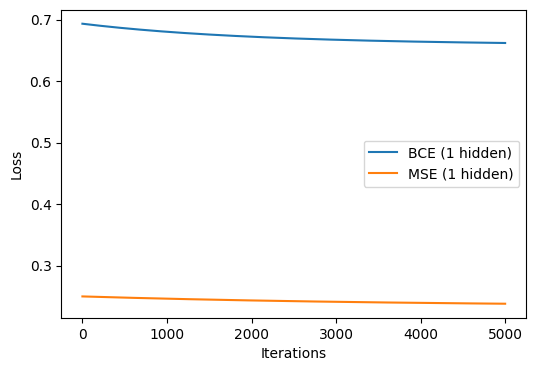

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(model_bce_1h.costs_, label='BCE (1 hidden)')
plt.plot(model_mse_1h.costs_, label='MSE (1 hidden)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()